In [1]:
import re
import sys
import glob
import pandas as pd
from functools import partial
from itertools import islice
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pyBigWig

In [3]:
sample_file = []
for file in glob.glob("40_bigwig/*-aa.bw"):
    m = re.search(r"([^/]+)-(100?ng)-(\d)-aa.bw", file)
    if m:
        kit, conc, rep = m.groups()
        sample_file.append({"kit": kit, "conc": conc, "rep": int(rep), "file": pyBigWig.open(file)})
a_file = sample_file[0]["file"] # This is an example file (to know number of contigs, etc)
sample_file = pd.DataFrame(sample_file)

In [4]:
CHROM = "chr1"
START = 119_983_000
WINDOW = 600
sample_file['vals'] = sample_file.file.map(lambda f: f.values(CHROM, START, START + WINDOW))

In [5]:
sample_file.head()

,conc,file,kit,rep,vals
0,100ng,<pyBigWig.bigWigFile object at 0x107dbc720>,Swift2S,2,"[6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, ..."
1,100ng,<pyBigWig.bigWigFile object at 0x107dbcae0>,NEB,4,"[17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17...."
2,100ng,<pyBigWig.bigWigFile object at 0x107dbcb10>,Nextera,1,"[18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 19...."
3,100ng,<pyBigWig.bigWigFile object at 0x107dbcbd0>,Nextera,4,"[15.0, 15.0, 15.0, 15.0, 16.0, 16.0, 16.0, 17...."
4,10ng,<pyBigWig.bigWigFile object at 0x1a19ee0f90>,Kapa,4,"[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 9.0, 9.0, 9.0, ..."


In [6]:
means = sample_file.groupby(["kit", "conc"]).vals.apply(lambda x: np.array(x.tolist()).mean(axis=0).tolist())

In [7]:
sample_file_100ng = sample_file[sample_file.conc == '100ng']

In [8]:
kits = list(set(sample_file_100ng.kit))

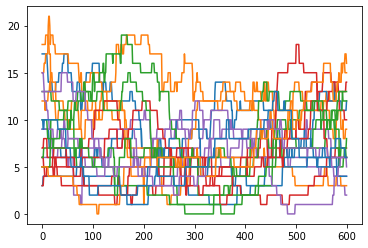

In [9]:
for _, row in sample_file_100ng.iterrows():
    plt.plot(row['vals'], "C{}".format(kits.index(row.kit)))
plt.show()

In [10]:
sample_file_long = sample_file.vals.apply(pd.Series) \
        .merge(sample_file, left_index=True, right_index=True) \
        .drop(["vals"], axis=1) \
        .melt(id_vars=['conc', 'kit', 'file', 'rep'], var_name="pos", value_name="coverage")

In [11]:
sample_file_long_df100 = sample_file_long[sample_file_long.conc == '100ng']

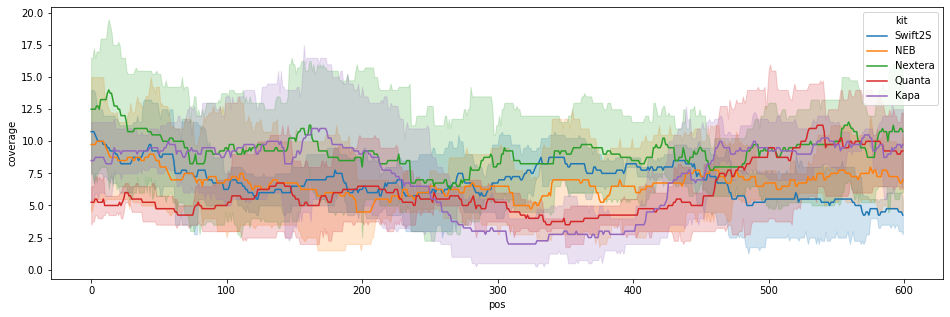

In [12]:
plt.figure(figsize=(16, 5))
sns.lineplot(x="pos", y="coverage", hue="kit", data=sample_file_long_df100)

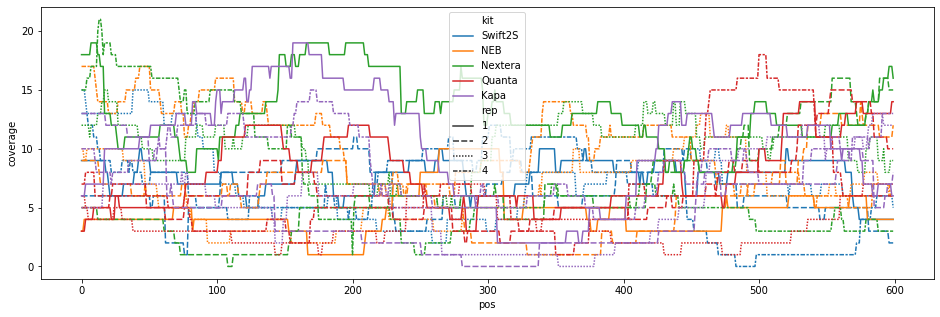

In [13]:
plt.figure(figsize=(16, 5))
sns.lineplot(x="pos", y="coverage", hue="kit", style="rep", data=sample_file_long_df100)

## Large scale statistics

In [14]:
GENOME_SIZE = sum(a_file.chroms().values())

In [15]:
chrom_list = list(a_file.chroms().items())

In [16]:
step_len = int(chrom_list[0][1] / 1e3)

In [17]:
for chrom, length in chrom_list:
    nbins = length // step_len
    if nbins > 0:
        lines = np.zeros((nbins, len(sample_file_100ng)))
        for ifile, file in enumerate(sample_file_100ng.file):
            lines[:, ifile] = file.stats(chrom, 0, step_len)
        print(lines.shape)
        

(1000, 20)
(972, 20)
(796, 20)
(764, 20)
(729, 20)
(686, 20)
(640, 20)
(582, 20)
(555, 20)
(537, 20)
(542, 20)
(535, 20)
(459, 20)
(429, 20)
(409, 20)
(362, 20)
(334, 20)
(322, 20)
(235, 20)
(258, 20)
(187, 20)
(204, 20)
(626, 20)
(229, 20)
(1, 20)
(7, 20)
(1, 20)
(1, 20)
